# Customer Lifetime Value Prediction Model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

In [ ]:
# Load datasets
transactions = pd.read_csv(r"C:\Users\bollejayanthsriteja\OneDrive\Desktop\Project\transactions.csv")  # Example file
customers = pd.read_csv(r"C:\Users\bollejayanthsriteja\OneDrive\Desktop\Project\customers.csv")        # Contains customer_id

In [ ]:
# Merge datasets on customer_id
data = pd.merge(transactions, customers, on="customer_id", how="inner")

In [ ]:
# Convert purchase_date to datetime
data['purchase_date'] = pd.to_datetime(data['purchase_date'])

In [ ]:
# Feature Engineering: Recency, Frequency, AOV
current_date = data['purchase_date'].max()

features = data.groupby("customer_id").agg({
    "purchase_date": lambda x: (current_date - x.max()).days,  # Recency
    "transaction_id": "count",                                  # Frequency
    "purchase_amount": "mean"                                   # AOV
}).reset_index()

features.columns = ["customer_id", "recency", "frequency", "aov"]

In [ ]:
# Compute true LTV (total spend per customer)
ltv = data.groupby("customer_id")["purchase_amount"].sum().reset_index()
ltv.columns = ["customer_id", "ltv"]

In [ ]:
# Merge features and target
features = pd.merge(features, ltv, on="customer_id")

In [ ]:
# Define input and target
X = features[["recency", "frequency", "aov"]]
y = features["ltv"]

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Model training
model = XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, ...)

In [14]:
# Prediction and evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 7.09, RMSE: 11.45


In [ ]:
# Predict LTV for all customers
features["predicted_LTV"] = model.predict(X)

In [ ]:
# Segment customers based on predicted LTV
features["segment"] = pd.qcut(features["predicted_LTV"], q=4, labels=["Low", "Medium", "High", "Very High"])

In [ ]:
# Export results
features.to_csv("ltv_predictions.csv", index=False)

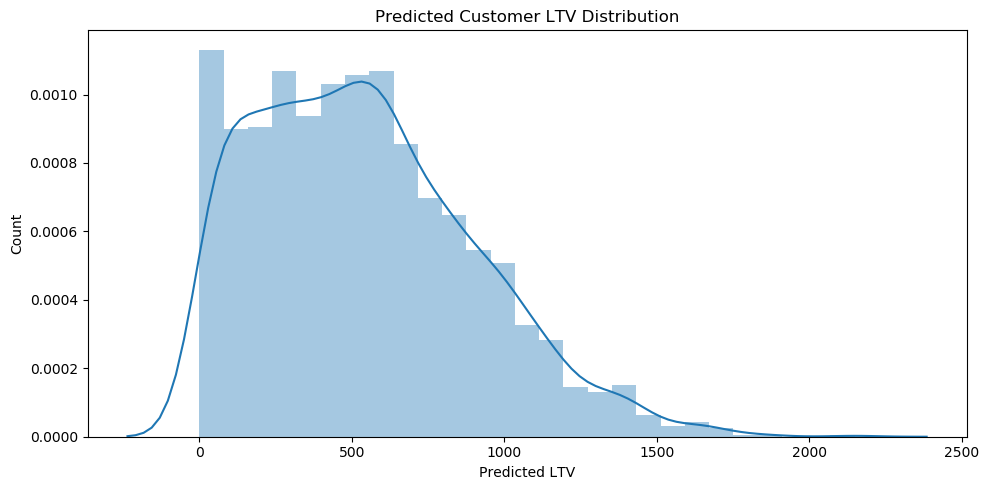

In [ ]:
# Visualization: LTV Distribution
plt.figure(figsize=(10, 5))
sns.distplot(features["predicted_LTV"], kde=True, hist=True)
plt.title("Predicted Customer LTV Distribution")
plt.xlabel("Predicted LTV")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("ltv_distribution.png")
plt.show()

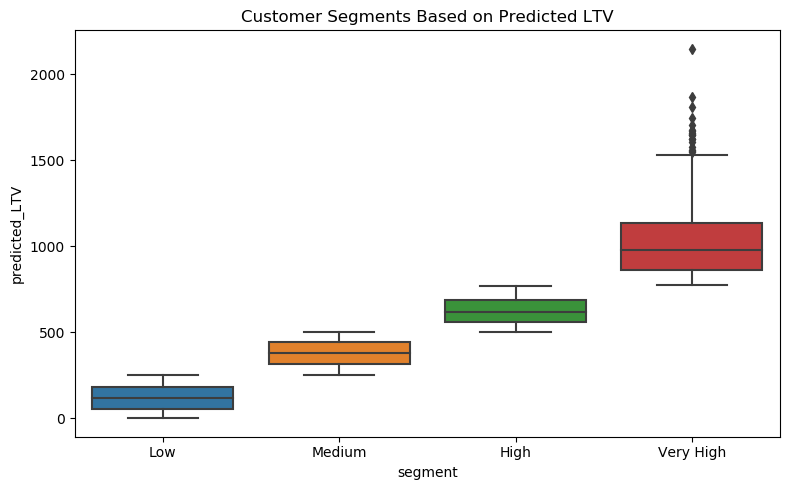

In [ ]:
# Visualization: LTV by Segment
plt.figure(figsize=(8, 5))
sns.boxplot(data=features, x="segment", y="predicted_LTV")
plt.title("Customer Segments Based on Predicted LTV")
plt.tight_layout()
plt.savefig("ltv_segments.png")
plt.show()